In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
import torch.optim as optim
import random
from torchvision.transforms import ToTensor, Normalize, Compose
from sklearn.model_selection import KFold

import torchmetrics
from torchmetrics import F1Score, Accuracy

%matplotlib inline

In [2]:
project_name='rock-paper-scissors'

In [3]:
# Data directory
data_dir = './dataset'
print(os.listdir(data_dir))

# Classes
classes = os.listdir(data_dir + "/train")
print(classes)

['test', 'train', 'validation']
['paper', 'rock', 'scissors']


In [4]:
stats=((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

train_tfms = tt.Compose([tt.CenterCrop(224),
                         tt.Resize((32,32)), 
                         tt.RandomHorizontalFlip(), 
                         tt.ToTensor(), 
                         tt.Normalize(*stats,inplace=True)])

valid_tfms = tt.Compose([tt.CenterCrop(224),tt.Resize((32,32)),tt.ToTensor(), tt.Normalize(*stats)])

In [5]:
# Datasets
train_dataset = ImageFolder(data_dir+'/train', train_tfms)
valid_dataset = ImageFolder(data_dir+'/validation', valid_tfms)
test_dataset = ImageFolder(data_dir+'/test', valid_tfms)

In [ ]:
len(test_dataset)

In [6]:
batch_size = 64
num_of_classes = len(classes)
num_of_classes

3

In [7]:
#Data loaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=3, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=3, pin_memory=True)

In [ ]:
def show_images(dataloader):
    for images, labels in dataloader:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break


In [ ]:
show_images(train_dataloader)

In [8]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [9]:
device = get_default_device()
device

device(type='cuda')

In [10]:
# Moving Dataset on the device('Cuda' if available)
train_dataloader = DeviceDataLoader(train_dataloader, device)

In [ ]:
# Define the ResNet9 model
class ResNet9(nn.Module):
    def __init__(self):
        super(ResNet9, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
#         self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )
        
#         self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
#         self.fc = nn.Linear(512, 3)
        
        self.fc = nn.Sequential(nn.MaxPool2d(4),
                                nn.Flatten(), 
                                nn.Dropout(0.2),
                                nn.Linear(512, num_of_classes))

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
#         x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
#         x = self.avgpool(x)
#         x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = F.softmax(x, dim=1)
        return x

In [11]:
class SmallResNet9(nn.Module):
    def __init__(self):
        super(SmallResNet9, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
#         self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

#         self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
#         self.fc = nn.Linear(256, num_of_classes)
        
        self.fc = nn.Sequential(nn.MaxPool2d(4), 
                      nn.Flatten(), 
                      nn.Dropout(0.2),
                      nn.Linear(256, num_of_classes))

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
#         x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
#         x = self.avgpool(x)
#         x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = F.softmax(x, dim=1)
        return x

In [12]:
k = 10
number_of_epochs = 100
learning_rate = 0.001
weight_decay = 1e-4

In [13]:
# Training function
def train(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    return epoch_loss

In [ ]:
# # Evaluation function
# def evaluate(model, val_loader):
#     model.eval()
#     all_labels = []
#     all_preds = []
#     with torch.no_grad():
#         for inputs, labels in val_loader:
#             inputs = inputs.to(device)
#             labels = labels.to(device)
#             outputs = model(inputs)
#             _, preds = torch.max(outputs, 1)
#             all_labels.append(labels.cpu().numpy())
#             all_preds.append(preds.cpu().numpy())
#     all_labels = np.concatenate(all_labels)
#     all_preds = np.concatenate(all_preds)
#     accuracy = accuracy_score(all_labels, all_preds)
#     return accuracy

In [14]:
def evaluate(model, val_loader):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_labels.append(labels.cpu())
            all_preds.append(preds.cpu())
    all_labels = torch.cat(all_labels)
    all_preds = torch.cat(all_preds)
    accuracy = Accuracy(task="multiclass", num_classes=num_of_classes).to(device)
    return accuracy(all_preds, all_labels)


In [15]:
# K-fold cross-validation

kf = KFold(n_splits=k, shuffle=True)

# Initialize lists to store training and validation losses and accuracies


# Train and validate for each fold
for fold, (train_indices, val_indices) in enumerate(kf.split(train_dataset)):
    print(f'Fold {fold + 1}/{k}')
    
    # Create subset datasets and dataloaders for this fold
    train_subset = Subset(train_dataset, train_indices)
    val_subset = Subset(train_dataset, val_indices)
    train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)
    # Define model,
    model = SmallResNet9()
    model.to(device)
    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
#     optimizer = optim.Adam(model.parameters(), learning_rate)

    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    # Train and validate for this fold
    for epoch in range(number_of_epochs):
        train_loss = train(model, train_loader, criterion, optimizer)
#         val_loss = evaluate(model, val_loader)
        val_loss = train(model,val_loader,criterion,optimizer)
        val_accuracy = evaluate(model, val_loader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        print(f'Epoch {epoch + 1} - Train loss: {train_loss:.4f} - Val loss: {val_loss:.4f} - Val accuracy: {val_accuracy:.4f}')
    
    torch.save(model, f'fold{fold}.pth')
    
# Print overall validation accuracy
# print(f'Overall validation accuracy: {np.mean(val_accuracies):.4f}')


Fold 1/3
Epoch 1 - Train loss: 0.9592 - Val loss: 1.3148 - Val accuracy: 0.3298
Epoch 2 - Train loss: 1.2120 - Val loss: 1.2169 - Val accuracy: 0.3330
Epoch 3 - Train loss: 0.9275 - Val loss: 1.2209 - Val accuracy: 0.3995
Epoch 4 - Train loss: 0.8450 - Val loss: 1.2088 - Val accuracy: 0.5613
Epoch 5 - Train loss: 0.7494 - Val loss: 1.1723 - Val accuracy: 0.6675
Epoch 6 - Train loss: 0.6982 - Val loss: 1.1361 - Val accuracy: 0.6738
Epoch 7 - Train loss: 0.6933 - Val loss: 1.0679 - Val accuracy: 0.6901
Epoch 8 - Train loss: 0.6799 - Val loss: 1.0870 - Val accuracy: 0.7466
Epoch 9 - Train loss: 0.6727 - Val loss: 1.0505 - Val accuracy: 0.6199
Epoch 10 - Train loss: 0.6471 - Val loss: 1.0006 - Val accuracy: 0.8387
Epoch 11 - Train loss: 0.6407 - Val loss: 0.9484 - Val accuracy: 0.7162
Epoch 12 - Train loss: 0.6402 - Val loss: 0.9506 - Val accuracy: 0.8319
Epoch 13 - Train loss: 0.6310 - Val loss: 0.8828 - Val accuracy: 0.8482
Epoch 14 - Train loss: 0.6232 - Val loss: 0.8841 - Val accuracy:

Epoch 15 - Train loss: 0.6366 - Val loss: 0.9356 - Val accuracy: 0.7690
Epoch 16 - Train loss: 0.6173 - Val loss: 0.9032 - Val accuracy: 0.8428
Epoch 17 - Train loss: 0.6146 - Val loss: 0.8655 - Val accuracy: 0.8937
Epoch 18 - Train loss: 0.6057 - Val loss: 0.8251 - Val accuracy: 0.9005
Epoch 19 - Train loss: 0.5996 - Val loss: 0.7737 - Val accuracy: 0.9329
Epoch 20 - Train loss: 0.5984 - Val loss: 0.7755 - Val accuracy: 0.9204
Epoch 21 - Train loss: 0.5941 - Val loss: 0.7356 - Val accuracy: 0.9340
Epoch 22 - Train loss: 0.5914 - Val loss: 0.7253 - Val accuracy: 0.9329
Epoch 23 - Train loss: 0.5877 - Val loss: 0.7109 - Val accuracy: 0.9329
Epoch 24 - Train loss: 0.5858 - Val loss: 0.6993 - Val accuracy: 0.9350
Epoch 25 - Train loss: 0.5840 - Val loss: 0.6872 - Val accuracy: 0.9408
Epoch 26 - Train loss: 0.5807 - Val loss: 0.6822 - Val accuracy: 0.9529
Epoch 27 - Train loss: 0.5783 - Val loss: 0.6707 - Val accuracy: 0.9529
Epoch 28 - Train loss: 0.5763 - Val loss: 0.6628 - Val accuracy:

Epoch 29 - Train loss: 0.5748 - Val loss: 0.6493 - Val accuracy: 0.9361
Epoch 30 - Train loss: 0.5731 - Val loss: 0.6426 - Val accuracy: 0.9324
Epoch 31 - Train loss: 0.5725 - Val loss: 0.6401 - Val accuracy: 0.9476
Epoch 32 - Train loss: 0.5702 - Val loss: 0.6375 - Val accuracy: 0.9481
Epoch 33 - Train loss: 0.5688 - Val loss: 0.6342 - Val accuracy: 0.9513
Epoch 34 - Train loss: 0.5671 - Val loss: 0.6306 - Val accuracy: 0.9560
Epoch 35 - Train loss: 0.5661 - Val loss: 0.6290 - Val accuracy: 0.9597
Epoch 36 - Train loss: 0.5655 - Val loss: 0.6233 - Val accuracy: 0.9471
Epoch 37 - Train loss: 0.5637 - Val loss: 0.6180 - Val accuracy: 0.9597
Epoch 38 - Train loss: 0.5651 - Val loss: 0.6229 - Val accuracy: 0.9471
Epoch 39 - Train loss: 0.5642 - Val loss: 0.6142 - Val accuracy: 0.9696
Epoch 40 - Train loss: 0.5615 - Val loss: 0.6163 - Val accuracy: 0.9665
Epoch 41 - Train loss: 0.5625 - Val loss: 0.6140 - Val accuracy: 0.9649
Epoch 42 - Train loss: 0.5608 - Val loss: 0.6144 - Val accuracy:

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [16]:
# Saving the model
torch.save(model, './saved_model.pth')

In [17]:
# Function to plot the losses
def plot_losses():
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

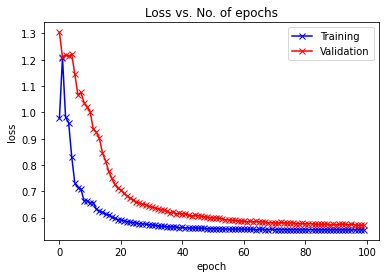

In [18]:
plot_losses()

In [19]:
test_ds = ImageFolder(data_dir+'/test', valid_tfms)
test_dl = DataLoader(test_ds, batch_size, num_workers=3, pin_memory=True)
test_dl = DeviceDataLoader(test_dl, device)

In [31]:
# Testing the model
test_model = SmallResNet9()
PATH = 'fold1.pth'
test_model = torch.load(PATH, map_location = device)
test_model.to(device)

SmallResNet9(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size

In [32]:
test_model.eval()
# correct = 0
# total = 0
# with torch.no_grad():
#     for data in test_dl:
#         images, labels = data
#         images, labels = images.to(device), labels.to(device)
#         outputs = test_model(images)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

# print('Accuracy of the ResNet9 model on the %d test images: %d %%' % (total, 100 * correct / total))

def evaluate_test_data(model, val_loader):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = test_model(inputs)
            _, preds = torch.max(outputs, 1)
            all_labels.append(labels)
            all_preds.append(preds)
    all_labels = torch.cat(all_labels)
    all_preds = torch.cat(all_preds)
    f1 = F1Score(task="multiclass", num_classes=num_of_classes,average='weighted').to(device)
    a = f1(all_preds, all_labels)
    acc = Accuracy(task="multiclass", num_classes=num_of_classes).to(device)
    b = acc(all_preds, all_labels)
    print('F1 Score:- ', a)
    print('Accuracy:-', b)


In [33]:
evaluate_test_data(test_model,test_dl)

F1 Score:-  tensor(0.6263, device='cuda:0')
Accuracy:- tensor(0.6184, device='cuda:0')


In [23]:
test_model.eval()
# correct = 0
# total = 0
# with torch.no_grad():
#     for data in test_dl:
#         images, labels = data
#         images, labels = images.to(device), labels.to(device)
#         outputs = test_model(images)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

# print('Accuracy of the ResNet9 model on the %d test images: %d %%' % (total, 100 * correct / total))

def evaluate_test_data_numpy(model, val_loader):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = test_model(inputs)
            _, preds = torch.max(outputs, 1)
            all_labels.append(labels.cpu().numpy())
            all_preds.append(preds.cpu().numpy())
    all_labels = np.concatenate(all_labels)
    all_preds = np.concatenate(all_preds)
    f1score = f1_score(all_labels, all_preds, average='weighted')
    accuracy = accuracy_score(all_labels, all_preds)
    print('F1 Score:- ', f1score)
    print('Accuracy:- ', accuracy)

In [24]:
evaluate_test_data_numpy(test_model,test_dl)

NameError: name 'f1_score' is not defined

In [ ]:
target = torch.tensor([0, 1, 2, 0, 1, 2])
preds = torch.tensor([0, 2, 1, 0, 0, 1])

f1 = F1Score(task="multiclass", num_classes=3)
a = f1(preds, target)

accuracy = Accuracy(task="multiclass", num_classes=3)
b = accuracy(preds, target)

print(a)
print(b)